In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import *
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import pandas as pd

In [2]:
## Get the dataset as numpy array

data = pd.read_csv('CDMS_Dataset.csv', sep=',')

features = list(data.columns)[1:]
x_data = data.values[:,1:-1]
y_data = data.values[:, -1]
n_features = len(features)

In [3]:
y_norm = -41.9 # largest y dimension to be used to normalize y data
x_mean = np.mean(x_data, axis = 0)
x_std  = np.std(x_data, axis = 0)

In [4]:
# Split data into train and test sets

def split_data(split_type='random', labels = []):
    if split_type == 'random':
        X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
    if split_type == 'label':
        X_train = data.loc[~data[features[-1]].isin(labels)].values[:, 1:-1]
        X_test = data.loc[data[features[-1]].isin(labels)].values[:, 1:-1]
        y_train =  data.loc[~data[features[-1]].isin(labels)].values[:, -1]
        y_test = data.loc[data[features[-1]].isin(labels)].values[:, -1]    
        
    X_train = (X_train - x_mean)/x_std
    X_test  = (X_test - x_mean)/x_std
    y_train = y_train/y_norm
    y_test  = y_test/y_norm
    
    return X_train, X_test, y_train, y_test

In [11]:
class CDMS_MLSuite:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test


class CDMS_PCA(CDMS_MLSuite):
    def __init__(self, X_train, y_train, X_test, y_test, n_components):
        super().__init__(X_train, y_train, X_test, y_test)
        self.pca = PCA(n_components = n_components)
        self.pca.fit(self.X_train)
        print("Number of principal components chosen = {}".format(self.pca.n_components_))
    
    
    def get_ncomponents(self):
        return self.pca.n_components_
    
    def get_variances(self):
        return self.pca.explained_variance_
    
    def get_variance_ratios(self):
        return self.pca.explained_variance_ratio_
    
    def do_PCR(self):
        print("Performing Linear regression using principal components and evaluating with test data")
        X_train_pc = self.pca.transform(self.X_train)
        X_test_pc = self.pca.transform(self.X_test)
        y_train = self.y_train
        y_test = self.y_test
        LR_PCA = LinearRegression().fit(X_train_pc, y_train)
        
        y_train_pred_pc = LR_PCA.predict(X_train_pc)
        MSE_train = np.sqrt(np.mean((y_train*y_norm - y_train_pred_pc*y_norm)**2))
        
        y_test_pred_pc = LR_PCA.predict(X_test_pc)
        MSE_test = np.sqrt(np.mean((y_test*y_norm - y_test_pred_pc*y_norm)**2))
        
        print("RMSE from train data = {}".format(MSE_train))
        print("RMSE from test data = {}".format(MSE_test))
        
        fig = plt.figure(figsize=(8,8))
        plt.scatter(y_train*y_norm, y_train_pred_pc*y_norm, marker='x', s=100, color='b', label='Train')
        plt.scatter(y_test*y_norm,  y_test_pred_pc*y_norm, marker='.', color='r', label='Test')
        plt.plot(y_train*y_norm, y_train*y_norm, color='k')
        plt.xlabel("True Value")
        plt.ylabel("Predicted Value")
        plt.legend(fontsize = 20)
        plt.show()
        
        
class CDMS_GPR(CDMS_MLSuite):
    def __init__(self, X_train, y_train, X_test, y_test):
        super().__init__(X_train, y_train, X_test, y_test)
        kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
               + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
        self.gp = GPR(kernel=kernel, alpha=0.0).fit(X_train, y_train)
        
    def do_GPR(self):
        print("Performing Gaussian Process Regression with RBF + WhiteNoise Kernel and evaluating with test data")
        y_train_pred, y_cov_train_pred = self.gp.predict(X_train, return_cov=True)
        MSE_train = np.sqrt(np.mean((y_train*y_norm - y_train_pred*y_norm)**2))
        
        y_test_pred, y_cov_test_pred = self.gp.predict(X_test, return_cov=True)
        MSE_test = np.sqrt(np.mean((y_test*y_norm - y_test_pred*y_norm)**2))
        
        print("RMSE from train data = {}".format(MSE_train))
        print("RMSE from test data = {}".format(MSE_test))
        
        fig = plt.figure(figsize=(8,8))
        plt.errorbar(y_train*y_norm, 
                    y_train_pred*y_norm,
                    fmt='x', 
                    yerr = np.sqrt(np.diag(y_cov_train_pred))*(-1*y_norm),
                    markersize=12, 
                    color='b', 
                    label='Train')
         
        plt.errorbar(y_test*y_norm,  
                    y_test_pred*y_norm,
                    yerr = np.sqrt(np.diag(y_cov_test_pred))*(-1*y_norm),
                    fmt='.', 
                    color='r', 
                    label='Test')
        plt.plot(y_train*y_norm, y_train*y_norm, color='k')

        plt.xlabel("True Value")
        plt.ylabel("Predicted Value")
        plt.legend(fontsize = 20)
        plt.show()
    

Number of principal components chosen = 9
Performing Linear regression using principal components and evaluating with test data
RMSE from train data = 1.9949994189635827
RMSE from test data = 1.9659291427773666


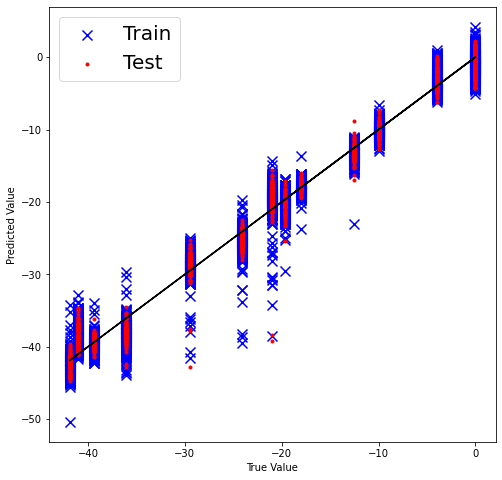

Number of principal components chosen = 19
Performing Linear regression using principal components and evaluating with test data
RMSE from train data = 1.442692730238046
RMSE from test data = 1.3993292402203692


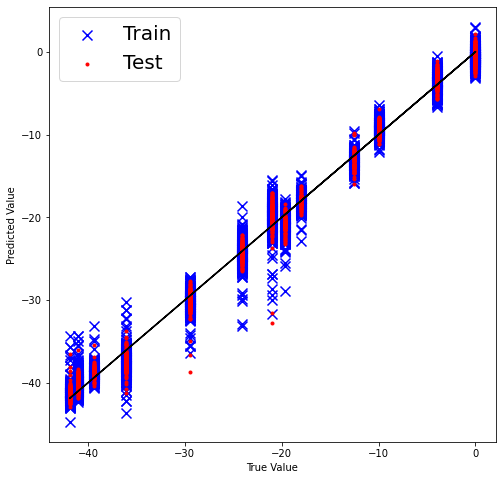

Performing Gaussian Process Regression with RBF + WhiteNoise Kernel and evaluating with test data
RMSE from train data = 0.13629450796423326
RMSE from test data = 0.8261598485235397


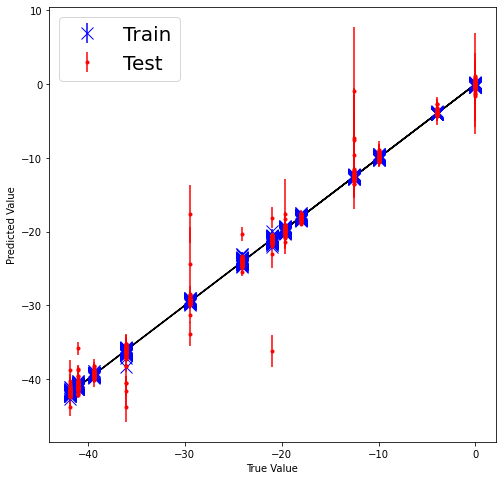

In [14]:
X_train, X_test, y_train, y_test = split_data()

pca = CDMS_PCA(X_train, y_train, X_test, y_test, n_components=0.97)
pca.do_PCR()
pca = CDMS_PCA(X_train, y_train, X_test, y_test, n_components=0.999999) 
# Equivalent to a Full Linear Regression
pca.do_PCR()
gpr = CDMS_GPR(X_train, y_train, X_test, y_test)
gpr.do_GPR()

Number of principal components chosen = 9
Performing Linear regression using principal components and evaluating with test data
RMSE from train data = 1.9851753559697254
RMSE from test data = 2.941986026094439


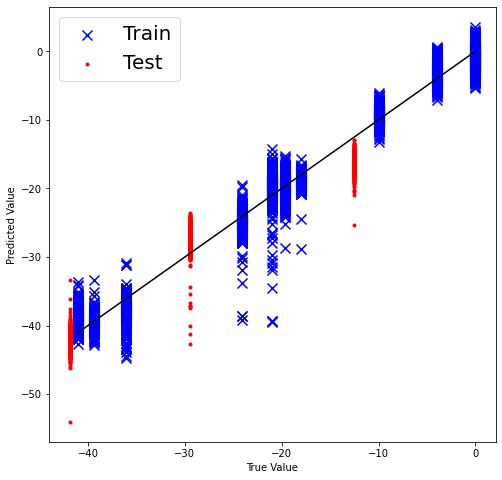

Number of principal components chosen = 19
Performing Linear regression using principal components and evaluating with test data
RMSE from train data = 1.415210866214222
RMSE from test data = 1.9964235488702495


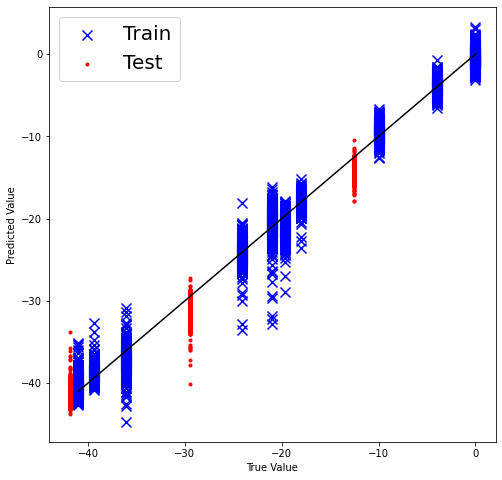

Performing Gaussian Process Regression with RBF + WhiteNoise Kernel and evaluating with test data
RMSE from train data = 0.569253797559666
RMSE from test data = 5.4627398287687665


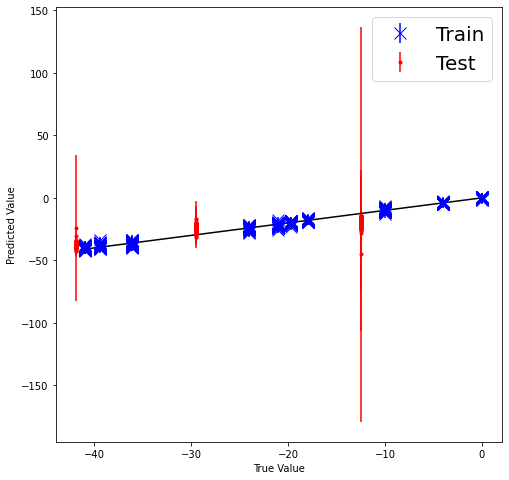

In [15]:
X_train, X_test, y_train, y_test = split_data('label', [-12.502, -29.5, -41.9])

pca = CDMS_PCA(X_train, y_train, X_test, y_test, n_components=0.97)
pca.do_PCR()
pca = CDMS_PCA(X_train, y_train, X_test, y_test, n_components=0.999999) 
# Equivalent to a Full Linear Regression
pca.do_PCR()
gpr = CDMS_GPR(X_train, y_train, X_test, y_test)
gpr.do_GPR()